Imports:

In [1]:
import os
import pika
import json
import glob
import re
import sys
import time
import numpy as np
import tensorflow as tf
from matplotlib import pyplot
from tensorflow.keras.models import model_from_json
import pandas as pd
from base.dm_test import dm_test
from base.bounds import bounds
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

Settings:

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # These lines should be called asap, after the os import
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Use CPU only by default
os.environ["PATH"] += os.pathsep + 'C:/Users/temp3rr0r/Anaconda3/Library/bin/graphviz'
# os.environ["PATH"] += os.pathsep + 'C:/ProgramData/Anaconda3/pkgs/graphviz-2.38.0-h6538335_1009/Library/bin/graphviz'
mimoOutputs = 3
year = 2019
lag = 1
model_location = "local"  # "madks-pc", "local"
islands_count = 4 # 4, 8, 16, 24, 32, 40

Helper functions:

In [3]:
def load_data(directory, file_prefix, mimo_outputs, gpu_rank=1, timesteps=1):
    """
    Reads time-series & variableCSV data from the disk and returns input & expected data matrices.
    :param directory: The directory path to read data from.
    :param file_prefix: File prefix for the CSV files.
    :param mimo_outputs: The amount of stations to predict, integer.
    :param gpu_rank: The rank of the worker/gpu.
    :return: Input and expected data matrices.
    """
    use_pandas = False  # TODO: for Hassio, use pandas to remove columns
    reduce_ts_length = True  # TODO: enable for air quality

    if not use_pandas:
        if data_manipulation["scale"] == 'standardize':
            r = np.genfromtxt(directory + file_prefix + "_ts_standardized.csv", delimiter=',')
        elif data_manipulation["scale"] == 'normalize':
            r = np.genfromtxt(directory + file_prefix + "_ts_normalized.csv", delimiter=',')
        else:
            r = np.genfromtxt(directory + file_prefix + "_ts.csv", delimiter=',')
        r = np.delete(r, [0], axis=1)  # Remove dates

        if data_manipulation["fp16"]:
            r.astype(np.float16, casting='unsafe')

        # TODO: test 1 station only printouts
        # r = np.delete(r, [1, 2, 3], axis=1)  # Remove all other ts

        # TODO: BETN073 only training. Removing stations 12, 66, 121 (and lags-1 of those)
        # r = np.delete(r, [0, 1, 3, 55, 56, 58], axis=1)  # Remove all other ts  # Lerp on missing values, comparable with other thesis

        if reduce_ts_length:

            # # TODO: greatly decrease r length for testing: 2014-2018 training, 2019 for testing
            row2014_01_01 = 366 - 1  # Lerp on missing values, comparable with other thesis
            row2019_12_31 = 2557
            r = r[row2014_01_01:row2019_12_31, :]

            # # # TODO: greatly decrease r length for testing: 2000-2009 training, 2010 for testing
            # row2000_01_01 = 3653 - 1  # Lerp on missing values, comparable with other thesis
            # row2010_12_31 = 7670
            # r = r[row2000_01_01:row2010_12_31, :]

            # TODO: greatly decrease r length for testing (365 days + 2 x X amount) and remove 40 vars
            # r = r[1:(365+60):]
            # r = np.delete(r, range(5, 50), axis=1)

            # # TODO: greatly decrease r length for testing: 2000-2001 training, 2002 for testing
            # row2000_01_01 = 3653 - 1  # Lerp on missing values, comparable with other thesis
            # row2002_12_31 = 4748
            # r = r[row2000_01_01:row2002_12_31, :]

            # TODO: greatly decrease r length for testing: 2007-2009 training, 2010 for testing
            # row2007_01_01 = 6210 - 1  # Lerp on missing values, comparable with other thesis
            # row2010_12_31 = 7670
            # r = r[row2007_01_01:row2010_12_31, :]

            # TODO: Greatly decrease r length for testing: 1990-2009 training, 2010 for testing
            # row2010_12_31 = 7670
            # r = r[0:row2010_12_31, :]

            # TODO: greatly decrease r length for testing: 2000-2012 training, 2013 for testing
            # row2000_01_01 = 3653 - 1
            # r = r[row2000_01_01:-1, :]

            # TODO: BETN073 training from O3_BETN016, BETN066, BETN073, O3_BETN121. Remove all other stations and lags.
            # TODO: O3_BETN016 -> 7, 104(lag 0, lag 1) O3_BETN066 -> 22, 119 O3_BETN073 -> 24, 121 O3_BETN121 -> 29, 126. Weather vars: 46 - 96
            # stations_range = [24, 121]  # Only BETN073 and lag-1
            # stations_range = [7, 22, 24, 29, 121, 104, 119, 126]  # 4 stations & lag-1:_BETN016, BETN066, BETN073, O3_BETN121
            # weather_variables_range = np.array(range(46, 96 + 1))
            # columns_range = np.append(stations_range, weather_variables_range)
            # r = r[:, columns_range]

            # TODO: greatly decrease r length for testing: 2014-2017 training, 2018 for testing
            # row2014_01_01 = 8777 - 1
            # r = r[row2014_01_01:-1, :]

            # TODO: greatly decrease r length for testing: 2010-2017 training, 2018 for testing
            # TODO: O3 from 1990
            # row2010_01_01 = 7307 - 1

            # TODO: greatly decrease r length for testing: 2010-2017 training, 2018 for testing
            # TODO: PM10 from 1995
            # row2010_01_01 = 5481 - 1


            # TODO: greatly decrease r length for testing: 2010-2017 training, 2018 for testing
            # TODO: O3 from 1995
            # row2010_01_01 = 7307 - 1
            # r = r[row2010_01_01:-1, :]

            # TODO: greatly decrease r length for testing: 2005-2017 training, 2018 for testing
            # TODO: O3 from 1995
            # row2005_01_01 = 5481 - 1
            # r = r[row2005_01_01:-1, :]

            # # TODO: PM10 83 stations. Train: 2008-2017 Test: 2018 TODO: station 67 has probs
            # row2008_01_01 = 4750 - 1
            # row2018_12_31 = 8767
            # r = r[row2008_01_01:row2018_12_31, :]

            # TODO: PM10 73 stations. Train: 2008-2011 Test: 2012
            # row2008_01_01 = 4749 - 1
            # row2012_12_31 = 6575
            # r = r[row2008_01_01:row2012_12_31, :]

            # # TODO: PM10 16 stations. Train: 2008-2011 Test: 2012
            # row2008_01_01 = 4749 - 1
            # row2018_12_31 = 8767
            # r = r[row2008_01_01:row2018_12_31, :]


        else:  # Remove first row of CSV columns for numpy
            row2 = 2 - 1
            r = r[row2:-1, :]

        print(data_manipulation["scale"])
        print("r[0, 0]", r[0, 0])
        print("r[-1, 0]", r[-1, 0])

        max_len = r.shape[1] - 1
        print('Variables: {}'.format(max_len))
        print('TimeSteps: {}'.format(r.shape[0]))
        x_data = r[:, mimo_outputs:max_len + 1]
        y_data_in = r[:, 0:mimo_outputs]
    else:
        # TODO: pandas select mimo outputs
        df = pd.read_csv(directory + file_prefix + "_ts_standardized.csv")
        mimo_columns = ["sensor.flower1_moisture", "sensor.flower1_conductivity", "sensor.flower1_temperature",
                        "sensor.flower1_light_intensity"]
        x_data_df = df.copy()
        x_data_df = x_data_df.drop(columns=mimo_columns)
        x_data_df = x_data_df.drop(columns=["datetime"])
        x_data = x_data_df.values
        y_data_in = df[mimo_columns].values
        print("x_data shape: {}".format(x_data.shape))
        print("y_data shape: {}".format(y_data_in.shape))

    y_data_in = np.array(y_data_in)
    x_data_3d_in, y_data_in = get_data_3d_lags(x_data, y_data_in, lags=timesteps)  # 3D: [samples, timesteps, features]

    print("x_data_3d_in shape: {}".format(x_data_3d_in.shape))
    print("y_data_in shape: {}".format(y_data_in.shape))

    # Normalize + standardize
    if not os.path.exists("foundModels/min_mse.pkl"):
        min_mse = sys.float_info.max
        print("Previous min_mse: {}".format(min_mse))
        original_df = pd.DataFrame({"min_mse": [min_mse]})
        original_df.to_pickle("foundModels/min_mse.pkl")
    else:
        min_mse = pd.read_pickle("foundModels/min_mse.pkl")['min_mse'][0]
        print("Previous min_mse: {}".format(min_mse))
        if os.path.exists("foundModels/full_{}_rank{}_parameters.pkl".format(modelLabel, gpu_rank)):
            full_model_parameters = pd.read_pickle(
                "foundModels/full_{}_rank{}_parameters.pkl".format(modelLabel, gpu_rank))[
                'full_{}_rank{}_parameters'.format(modelLabel, gpu_rank)][0]
            print("Previous full_{}_parameters: {}".format(modelLabel, full_model_parameters))

    # Normalize + standardize
    if not os.path.exists("foundModels/min_holdout_mse.pkl"):
        # TODO: holdout
        min_holdout_mse = sys.float_info.max
        print("Previous min_holdout_mse: {}".format(min_holdout_mse))
        original_holdout_df = pd.DataFrame({"min_holdout_mse": [min_holdout_mse]})
        original_holdout_df.to_pickle("foundModels/min_holdout_mse.pkl")

    else:
        min_holdout_mse = pd.read_pickle("foundModels/min_holdout_mse.pkl")['min_holdout_mse'][0]
        print("Previous min holdout_mse: {}".format(min_holdout_mse))
        if os.path.exists("foundModels/full_{}_rank{}_holdout_parameters.pkl".format(modelLabel, gpu_rank)):
            full_model_parameters = pd.read_pickle(
                "foundModels/full_{}_rank{}_holdout_parameters.pkl".format(modelLabel, gpu_rank))[
                'full_{}_rank{}_holdout_parameters'.format(modelLabel, gpu_rank)][0]
            print("Previous full_{}_holdout_parameters: {}".format(modelLabel, full_model_parameters))

    return x_data_3d_in, y_data_in

In [4]:
def init_gpu(gpu_rank):
    """
    Initializes a specific GPU only for this process.
    :param gpu_rank: Mapping from "rank" to GPU id (hardware).
    :return: None.
    """
    if 1 <= gpu_rank <= 8:  # Rank per gpu
        os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
        os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_rank - 1)

In [5]:
def get_data_3d_lags(x_data_in, y_data_in, lags=7):
    """
    Receives single-slice x,y data and adds repeating timesteps (lags).
    :param x_data_in: 2D numpy array of [samples, variables]
    :param y_data_in: 2D numpy array of [output1, output2, ...]
    :param lags: How many timesteps (lags) to add in each slice.
    :return: Two outputs: 3D numpy array of X [timesteps, lags, variables] and lagged Y [output1, output2, ...].
    """
    nb_samples = x_data_in.shape[0] - lags + 1
    num_features = x_data_in.shape[1]
    x_data_reshaped = np.zeros((nb_samples, lags, num_features))
    y_data_reshaped = np.zeros((nb_samples, y_data_in.shape[1]))

    for i in range(nb_samples):
        y_position = i + lags
        x_data_reshaped[i] = x_data_in[i:y_position]
        y_data_reshaped[i] = y_data_in[y_position - 1]

    return x_data_reshaped, y_data_reshaped

In [6]:

def diebold_mariano(expected, predicted_1, predicted_2, horizon=1, criterion="MSE", power=4):
    """
    Diebold-Mariano Test (1995) with modification suggested by Harvey et. al (1997) to statistically identify forecast
    accuracy equivalance for 2 sets of predictions  [1] [2].

    # See: https://pkg.robjhyndman.com/forecast/reference/dm.test.html#author
    # See: https://en.wikipedia.org/wiki/Misuse_of_p-values
    # References:
    # [1] Harvey, D., Leybourne, S., & Newbold, P. (1997). Testing the equality of
    #   prediction mean squared errors. International Journal of forecasting,
    #   13(2), 281-291.
    #
    # [2] Diebold, F. X. and Mariano, R. S. (1995), Comparing predictive accuracy,
    #   Journal of business & economic statistics 13(3), 253-264.

    :param expected: 1D or nD array of expected values
    :param predicted_1: 1D or nD array of predicted values from model 1
    :param predicted_2: 1D or nD array of predicted values from model 2
    :param horizon: steps-ahead horizon
    :param criterion: String value from: { "MAD", "MSE", "MAPE", "poly"}. Mean Absolute Deviation (MAD),
    Mean Squared Error (MSE), Mean Absolute Percentage Error (MAPE), polynomial.
    :param power: Integer in [1, data length] for polynomial criterion.
    :return: Tuple of DM statistic, p-value.
    """
    rt = dm_test(expected, predicted_1, predicted_2, h=horizon, crit=criterion)

    return rt.DM, rt.p_value

In [7]:
def diebold_mariano_naive(expected, predicted, naive_lags=1, horizon=1, criterion="MSE", power=4):
    """
    Diebold-Mariano Test (1995) of a model against a naive persistence model [1] [2].

    # See: https://pkg.robjhyndman.com/forecast/reference/dm.test.html#author
    # See: https://en.wikipedia.org/wiki/Misuse_of_p-values
    # References:
    # [1] Harvey, D., Leybourne, S., & Newbold, P. (1997). Testing the equality of
    #   prediction mean squared errors. International Journal of forecasting,
    #   13(2), 281-291.
    #
    # [2] Diebold, F. X. and Mariano, R. S. (1995), Comparing predictive accuracy,
    #   Journal of business & economic statistics 13(3), 253-264.

    :param predicted: 1D or nD array of predicted values from mo
    :param expected: 1D or nD array of expected valuesdel
    :param naive_lags: Lags to scale for. Default 1 for non-stationary data.
    :param horizon: steps-ahead horizon
    :param criterion: String value from: { "MAD", "MSE", "MAPE", "poly"}. Mean Absolute Deviation (MAD),
    Mean Squared Error (MSE), Mean Absolute Percentage Error (MAPE), polynomial.
    :param power: Integer in [1, data length] for polynomial criterion.
    :return: Tuple of DM statistic, p-value. Positive = 2nd series more accurate than 1st.
    """

    naive_series = mimo_shift(expected, naive_lags, fill_value=expected[0])

    return diebold_mariano(list(expected), list(naive_series), list(predicted), horizon, criterion, power)

In [8]:
def mean_absolute_scaled_error(expected, predicted, naive_lags=1):
    """
    Mean Absolute Scaled Error (MASE) [1]: MAE / MAE_Naive_lag.
    [1] Hyndman RJ, Koehler AB. Another look at measures of forecast accuracy. International Journal of Forecasting.
    2006;22(4):679–688. 10.1016/j.ijforecast.2006.03.001
    :param expected: 1D or nD array of expected values
    :param predicted: 1D or nD array of predicted values
    :param naive_lags: Lags to scale for. Default 1 for non-stationary data.
    :return: 1D or nD Mean Absolute Scaled Error (MASE).
    """
    return mean_absolute_error(
        expected, predicted) / mean_absolute_error(expected, mimo_shift(expected, naive_lags, fill_value=expected[0]))


def mimo_shift(array, lags, fill_value=np.nan):
    """
    Shift the 1D or nD time-series by num steps. Returns the Naive-lag time-series.
    :param array: 1D or nD input array.
    :param lags: Steps to shift/lag.
    :param fill_value: Value to fill in the first lag steps that are empty.
    :return: 1D or nD naive-lag time-series.
    """
    result = np.empty_like(array)
    if lags > 0:
        result[:lags] = fill_value
        result[lags:] = array[:-lags]
    elif lags < 0:
        result[lags:] = fill_value
        result[:lags] = array[-lags:]
    else:
        result[:] = array
    return result


def symmetric_mean_absolute_percentage_error(a, b):
    """
    Calculates symmetric Mean Absolute Percentage Error (sMAPE).
    :param a: actual values
    :param b: predicted values
    :return: sMAPE float.
    """
    a = np.reshape(a, (-1,))
    b = np.reshape(b, (-1,))
    return 100.0 * np.mean(2.0 * np.abs(a - b) / (np.abs(a) + np.abs(b))).item()


def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculates Mean Absolute Percentage Error (MAPE).
    :param y_true: actual values
    :param y_pred: predicted values
    :return: MAPE float.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # In %


def index_of_agreement(validation, prediction):
    """
    Calculates Index Of Agreement (IOA).
    :param validation: actual values
    :param prediction: predicted values
    :return: IOA float.
    """
    return 1 - (np.sum((validation - prediction) ** 2)) / (np.sum((np.abs(prediction -
      np.mean(validation)) + np.abs(validation - np.mean(validation))) ** 2))


def delete_model(model):
    """
    Memory Handling: Clear a tensorflow model from memory & with garbage collector.
    :param model: Tensorflow model to remove.
    :return:
    """
    # Memory handling
    del model  # Manually delete model
    tf.compat.v1.reset_default_graph()
    tf.keras.backend.clear_session()
    gc.collect()


def reduce_time_series_validation_fold_size(train, validation, max_validation_length=365):
    """
    If time-series fold validation array larger than the threshold (i.e 365 days), strip the starting validation excess
    and add it to the end of the training set.
    :param train: Indices of the time-series training set.
    :param validation: Indices of the time-series validation set.
    :param max_validation_length: Max validation array size.
    :return:
    """
    if len(validation) > max_validation_length:
        train = np.append(train, validation[0:len(validation) - max_validation_length])
        validation = validation[-max_validation_length:]
    return train, validation


Load data:

In [9]:
gpu_device = 1  # Set GPU (default: 1)

print("--- Usage:\n\tWorkerModelTrainer.py --gpu <integer (default: 1): 0 to N>\n\tor"
      "\n\tWorkerModelTrainer.py -g <integer (default: 1): 0 to N>")
if len(sys.argv) == 3:
    if str(sys.argv[1]) in ("--gpu", "-g"):
        gpu_device = int(sys.argv[2])
        print("-- Set to GPU: {}".format(gpu_device))  # TODO: Store gpu_device -> CSV field

print("--- Loading GPU {}...".format(gpu_device))
init_gpu(gpu_device)

print("--- Loading simulation settings...")
with open('settings/data_manipulation.json') as f:
    data_manipulation = json.load(f)
modelLabel = data_manipulation["modelLabel"]
data_manipulation["gpuDevice"] = gpu_device

if data_manipulation["fp16"]:
    import tensorflow as tf
    tf.keras.backend.set_epsilon(1e-4)
    tf.keras.backend.set_floatx('float16')
    print("--- Working with tensorflow.keras float precision: {}".format(tf.keras.backend.floatx()))

# Choose data


# TODO: Malta, 5 MIMO, reduced exogenous (corr-based)
data_manipulation["directory"] = "data/malta_reducedExogenous/"  # MT data
data_manipulation["filePrefix"] = "all_Malta_ozone_weather_reducedExogenous_2013To2020"
data_manipulation["mimoOutputs"] = 3  # 5 -> 3: Removed MT03, MT05 (dupliates since 2017 + in another island)

# TODO: Cyprus, 3 MIMO, reduced exogenous (corr-based)
# data_manipulation["directory"] = "data/cyprus_reducedExogenous/"  # CY data
# data_manipulation["filePrefix"] = "all_Cyprus_ozone_weather_reducedExogenous_2013To2020"
# data_manipulation["mimoOutputs"] = 3

print("--- Loading data...")
x_data_3d, y_data = load_data(data_manipulation["directory"], data_manipulation["filePrefix"],
                              data_manipulation["mimoOutputs"], timesteps=data_manipulation["timesteps"])

data_manipulation["rank"] = gpu_device
data_manipulation["bounds"] = bounds  # TODO: add bounds from modelsearch

iterations = data_manipulation["iterations"]
agents = data_manipulation["agents"]

--- Usage:
	WorkerModelTrainer.py --gpu <integer (default: 1): 0 to N>
	or
	WorkerModelTrainer.py -g <integer (default: 1): 0 to N>
--- Loading GPU 1...
--- Loading simulation settings...
--- Loading data...
standardize
r[0, 0] -1.3519954681159405
r[-1, 0] -1.352424341189002
Variables: 27
TimeSteps: 2192
x_data_3d_in shape: (2192, 1, 25)
y_data_in shape: (2192, 3)
Previous min_mse: 1.7976931348623157e+308
Previous min holdout_mse: 1.7976931348623157e+308


Load model:

In [10]:
json_file = open(f'runs/MT_64unitsMax_{islands_count}islands__2/{model_location}/foundModels/bestModelArchitecture.json', 'r')

loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# loaded_model.load_weights("runs/O3_2018_46_stations/foundModels/bestModelWeights.h5")
# loaded_model.load_weights("foundModels/bestModelWeights.h5")
loaded_model.load_weights(f"runs/MT_64unitsMax_{islands_count}islands__2/{model_location}/foundModels/bestModelWeights.h5")

Load test data:

In [11]:
# x_data, x_data_holdout = x_data_3d[:-365], x_data_3d[-365:]
# y_data, y_data_holdout = y_data[:-365], y_data[-365:]

In [12]:
holdout_max_validation_length = 365  # hours or 365 days
x_data, x_data_holdout = x_data_3d[:-holdout_max_validation_length], x_data_3d[-holdout_max_validation_length:]
y_data, y_data_holdout = y_data[:-holdout_max_validation_length], y_data[-holdout_max_validation_length:]

<AxesSubplot:>

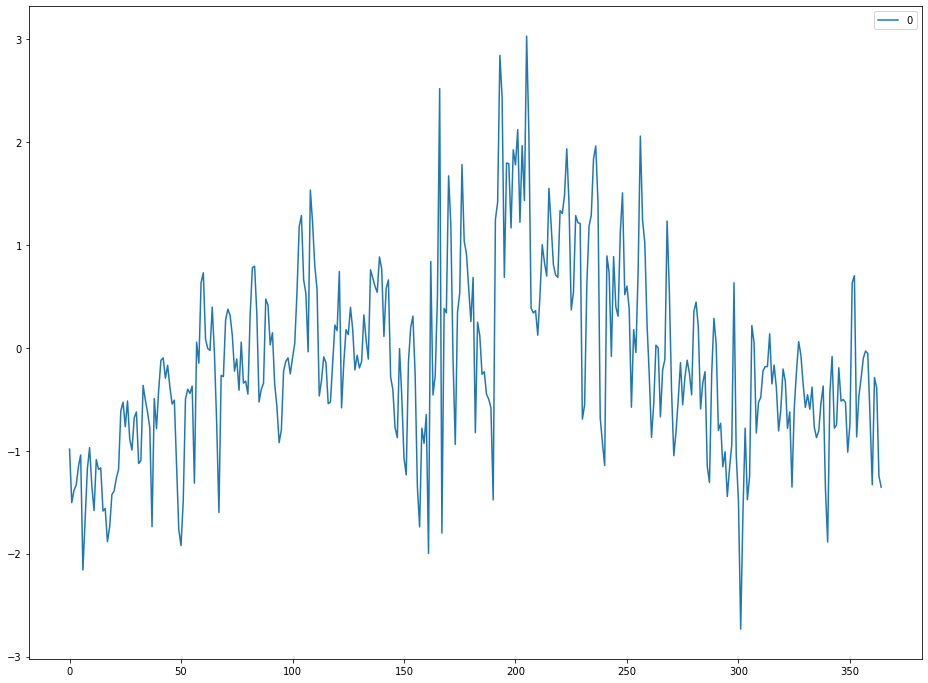

In [13]:
year_index = 0
pd.DataFrame(y_data_holdout[-365*year_index:-365*(year_index-1),0]).plot(figsize=(16, 12))

Calculate metrics:

In [14]:
holdout_prediction = loaded_model.predict(x_data_holdout)

In [15]:
sensor_mean = pd.read_pickle("data/malta_reducedExogenous/all_Malta_ozone_weather_reducedExogenous_2013To2020_ts_mean.pkl")
sensor_std = pd.read_pickle("data/malta_reducedExogenous/all_Malta_ozone_weather_reducedExogenous_2013To2020_ts_std.pkl")
sensor_mean = np.array(sensor_mean)
sensor_std = np.array(sensor_std)

predictionAll = (holdout_prediction * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
y_validationAll = (y_data_holdout * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]

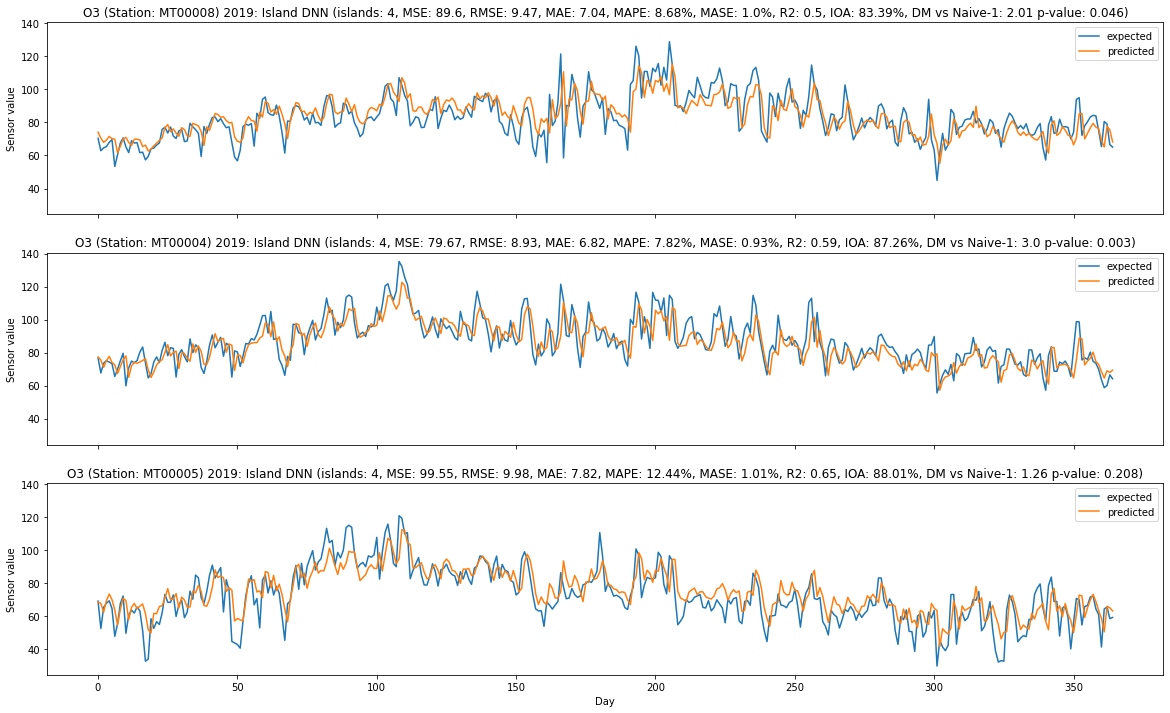

In [16]:
stations = ["MT00008", "MT00004", "MT00005"]
criterion = "MSE"  # Temp, use only MSE criterion
fig, ax = pyplot.subplots(nrows=len(stations), ncols=1, figsize=(20, 12), sharex=True, sharey=True)


for i in range(len(stations)):
    prediction = predictionAll[:,i]
    y_validation = y_validationAll[:,i]

    MSE = mean_squared_error(y_validation, prediction)
    RMSE = np.sqrt(MSE)
    MAE = mean_absolute_error(y_validation, prediction)
    MAPE = mean_absolute_percentage_error(y_validation, prediction)
    MASE = mean_absolute_scaled_error(y_validation, prediction)
    R2_score = r2_score(y_validation, prediction)
    IOA = index_of_agreement(y_validation, prediction)

    holdout_DM = diebold_mariano_naive(y_validation, prediction, criterion=criterion)

    ax[i].set_ylabel('Sensor value')
    ax[i].set_title('O3 (Station: {}) {}: Island DNN (islands: {}, MSE: {}, RMSE: {}, MAE: {}, MAPE: {}%, MASE: {}%, R2: {}, IOA: {}%, DM vs Naive-1: {} p-value: {})'.format(stations[i], year, islands_count, np.round(MSE,2), np.round(RMSE,2), np.round(MAE,2), np.round(MAPE,2), np.round(MASE,2), np.round(R2_score,2), np.round(IOA * 100,2), np.round(holdout_DM[0], 2), np.round(holdout_DM[1], 3)))
    ax[i].plot(y_validationAll[:,i])
    ax[i].plot(predictionAll[:,i])
    ax[i].legend(['expected', 'predicted'])
ax[len(stations)-1].set_xlabel('Day');

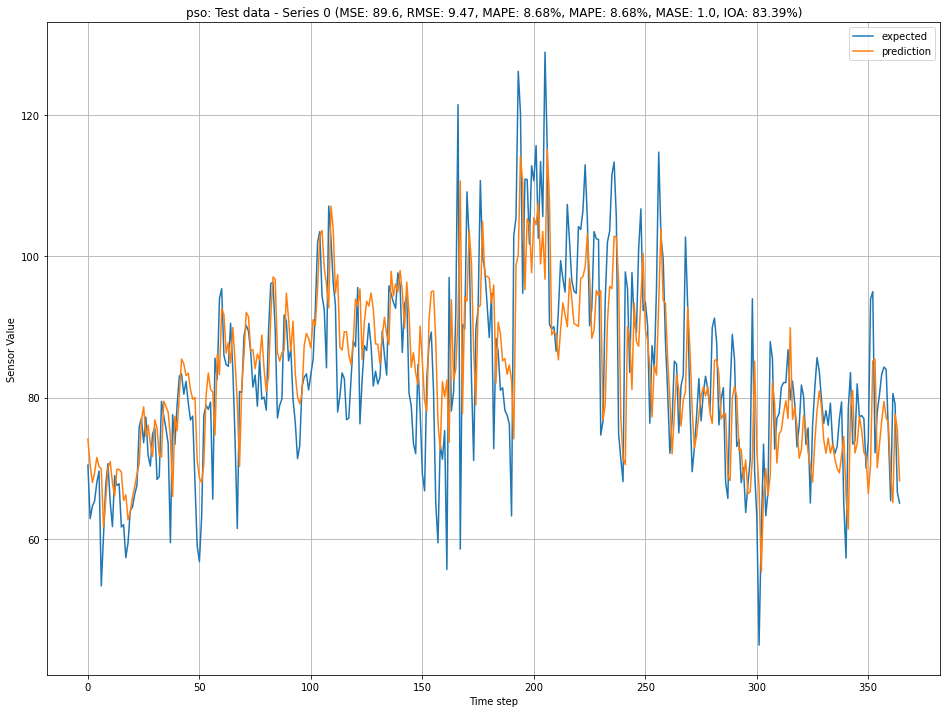

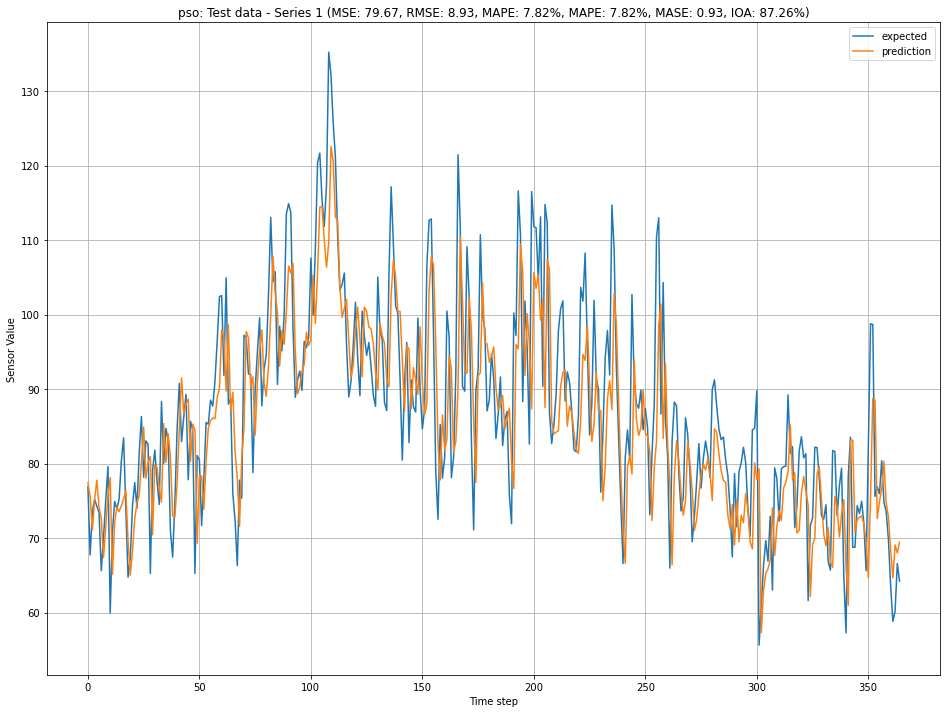

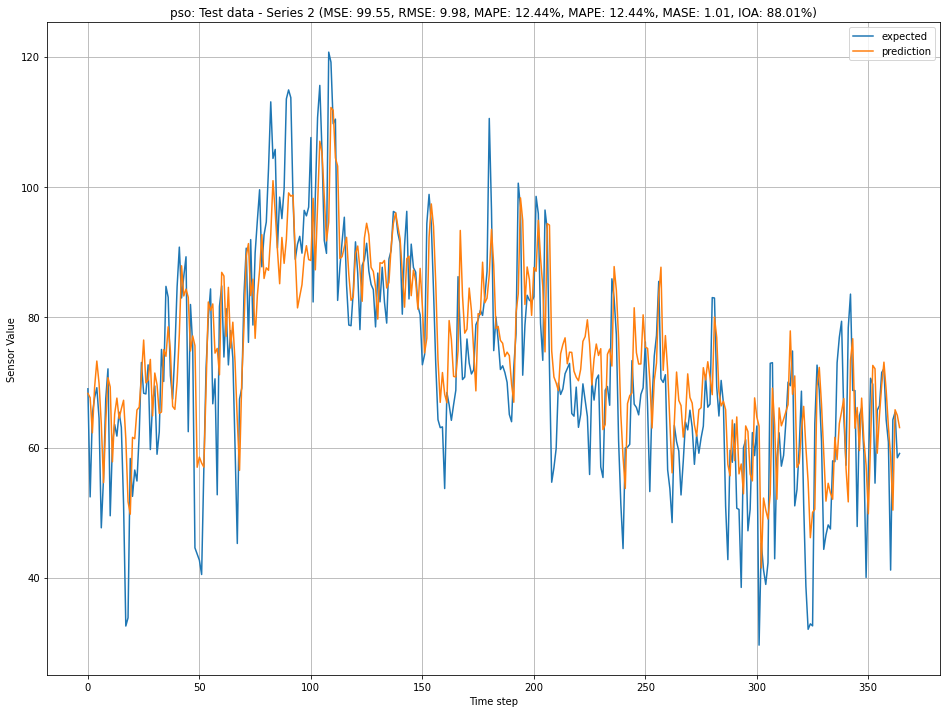

In [17]:
for i in range(len(stations)):

    prediction = predictionAll[:,i]
    y_validation = y_validationAll[:,i]

    MSE = mean_squared_error(y_validation, prediction)
    RMSE = np.sqrt(MSE)
    MAE = mean_absolute_error(y_validation, prediction)
    MAPE = mean_absolute_percentage_error(y_validation, prediction)
    MASE = mean_absolute_scaled_error(y_validation, prediction)
    R2_score = r2_score(y_validation, prediction)
    IOA = index_of_agreement(y_validation, prediction)

    pyplot.figure(figsize=(16, 12))  # Resolution 800 x 600
    pyplot.title("{}: Test data - Series {} (MSE: {}, RMSE: {}, MAPE: {}%, "
                 "MAPE: {}%, MASE: {}, IOA: {}%)"
            .format(modelLabel, i, np.round(MSE, 2), np.round(RMSE, 2),
                    np.round(MAPE, 2), np.round(MAPE, 2), np.round(MASE, 2),
                    np.round(IOA * 100, 2)))
    pyplot.plot(y_validation, label='expected')
    pyplot.plot(prediction, label='prediction')
    pyplot.xlabel("Time step")
    pyplot.ylabel("Sensor Value")
    pyplot.grid(True)
    pyplot.legend()

Min-max scaling test:

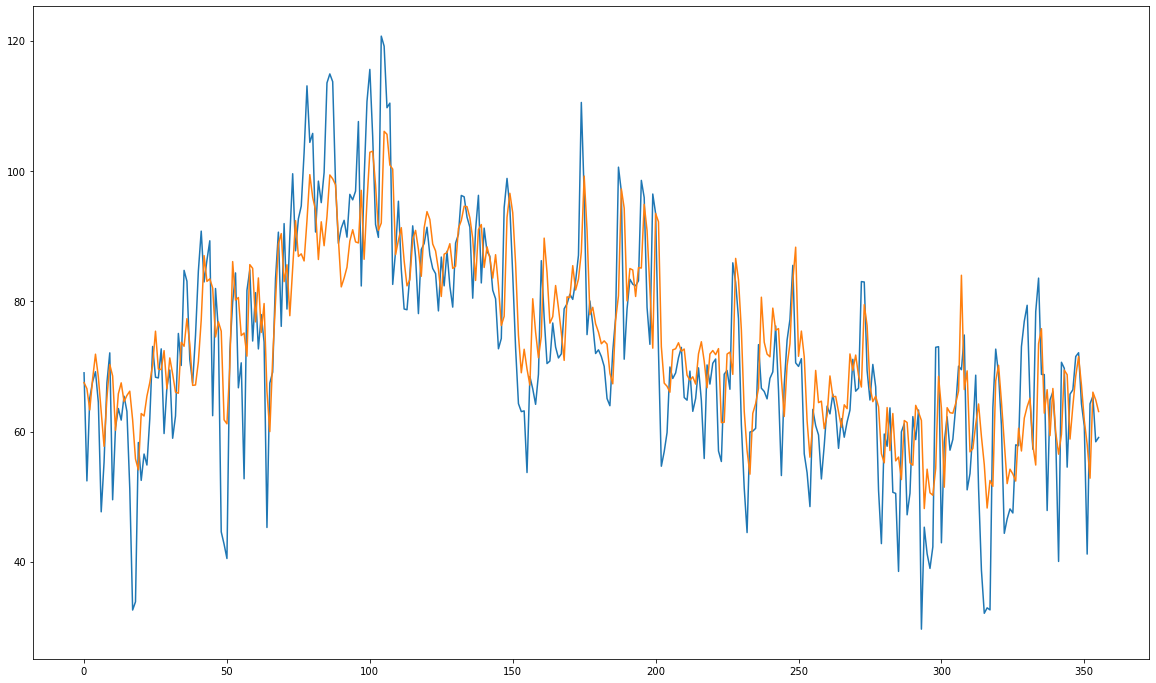

In [18]:
z = pd.read_csv(f"runs/MT_64unitsMax_{islands_count}islands__2/{model_location}/foundModels/svgToValues.csv")
z.index = z.x
# z = z.interpolate()
t = pd.read_csv(f"runs/MT_64unitsMax_{islands_count}islands__2/{model_location}/foundModels/svgToValues_predicted.csv")
t.index = t.x
# t = t.interpolate()

for idx, row in t.iterrows():
    # print(idx, row["x"], row["y_predicted"])
    z.loc[(z.x==idx),'y_predicted']=row["y_predicted"]

z["y2"] = z.y.max() - z.y
z["y_predicted2"] = z.y.max() - z.y_predicted
z = z.interpolate()

z.x = pd.to_numeric(z.x)
z.y = pd.to_numeric(z.y)
z.y2 = pd.to_numeric(z.y2)
z.y_predicted = pd.to_numeric(z.y_predicted)
z.y_predicted2 = pd.to_numeric(z.y_predicted2)

l = []
for val in z["y2"]:
    l.append([val])
scaler = MinMaxScaler(feature_range=(y_validationAll[:, 2].min(), y_validationAll[:, 2].max()))
scaler.fit(l)

l2 = scaler.transform(l)
m = []
for val in z["y_predicted2"]:
    m.append([val])
m2 = scaler.transform(m)

l2 = l2.astype(np.float)
m2 = m2.astype(np.float)

fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(20, 12), sharex=True, sharey=True)
ax.plot(l2)
ax.plot(m2)

In [19]:
prediction = m2
y_validation = l2

MSE = mean_squared_error(y_validation, prediction)
RMSE = np.sqrt(MSE)
MAE = mean_absolute_error(y_validation, prediction)
MAPE = mean_absolute_percentage_error(y_validation, prediction)
MASE = mean_absolute_scaled_error(y_validation, prediction)
R2_score = r2_score(y_validation, prediction)
IOA = index_of_agreement(y_validation, prediction)

holdout_DM = diebold_mariano_naive(list(y_validation.squeeze()), list(prediction.squeeze()), criterion=criterion)
holdout_DM

(2.409722480431641, 0.016472825513203653)

Test Read SVG tags:

In [20]:
import svgelements
from svgelements import *

In [21]:
svgelements.svg_parse

[('COMMAND', '[MmZzLlHhVvCcSsQqTtAa]'),
 ('SKIP', '[ ,\\t\\n\\x09\\x0A\\x0C\\x0D]+')]

In [22]:
from xml.dom import minidom

doc = minidom.parse("runs/IslandCountsFigures/MT/Islands4/gaIter90Rank1Series1HoldoutTestCamera.svg")
path_strings = [path.getAttribute('d') for path in doc.getElementsByTagName('path')]

doc.unlink()

In [23]:
path_strings

['M 0 432  L 576 432  L 576 0  L 0 0  z ',
 'M 72 384.48  L 518.4 384.48  L 518.4 51.84  L 72 51.84  z ',
 'M 92.290909 384.48  L 92.290909 51.84  ',
 'M 0 0  L 0 3.5  ',
 'M 31.78125 66.40625  Q 24.171875 66.40625 20.328125 58.90625  Q 16.5 51.421875 16.5 36.375  Q 16.5 21.390625 20.328125 13.890625  Q 24.171875 6.390625 31.78125 6.390625  Q 39.453125 6.390625 43.28125 13.890625  Q 47.125 21.390625 47.125 36.375  Q 47.125 51.421875 43.28125 58.90625  Q 39.453125 66.40625 31.78125 66.40625  z M 31.78125 74.21875  Q 44.046875 74.21875 50.515625 64.515625  Q 56.984375 54.828125 56.984375 36.375  Q 56.984375 17.96875 50.515625 8.265625  Q 44.046875 -1.421875 31.78125 -1.421875  Q 19.53125 -1.421875 13.0625 8.265625  Q 6.59375 17.96875 6.59375 36.375  Q 6.59375 54.828125 13.0625 64.515625  Q 19.53125 74.21875 31.78125 74.21875  z ',
 'M 148.035165 384.48  L 148.035165 51.84  ',
 'M 10.796875 72.90625  L 49.515625 72.90625  L 49.515625 64.59375  L 19.828125 64.59375  L 19.828125 46.734375  

In [24]:
path_strings_dict = [path.getAttribute('d') for path in doc.getElementsByTagName('line2d_27')]
# line2d_27

In [25]:
doc = minidom.parse("runs/IslandCountsFigures/MT/Islands4/gaIter90Rank1Series1HoldoutTestCamera.svg")

o = []
for path in doc.getElementsByTagName('path'):
    o.append(path.getAttribute('d'))
    o.append(path)
    break

doc.unlink()


In [26]:
o[1].getAttribute("d")

''

In [27]:
xml_doc = minidom.parse("runs/IslandCountsFigures/MT/Islands4/gaIter90Rank1Series1HoldoutTestCamera.svg")
# elements = xml_doc.getElementsByTagName('node')
elements = xml_doc.getElementsByTagName('g')
for element in elements:
    if element.hasAttribute('id') and element.getAttribute('id') == 'line2d_27':
        print(element.toxml())
        for path in element.getElementsByTagName('path'):
            print(path.getAttribute('d'))
            print(path.toxml())
    else:
        # print(element.toxml())
        pass
doc.unlink()

<g id="line2d_27">
      <path clip-path="url(#p46def5244c)" d="M 72 162.880897  L 518.4 162.880897  " style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"/>
     </g>
M 72 162.880897  L 518.4 162.880897  
<path clip-path="url(#p46def5244c)" d="M 72 162.880897  L 518.4 162.880897  " style="fill:none;stroke:#b0b0b0;stroke-linecap:square;stroke-width:0.8;"/>


In [28]:
doc = minidom.parse("runs/IslandCountsFigures/MT/Islands4/gaIter90Rank1Series1HoldoutTestCamera.svg")

o = []
for path in doc.getElementsByTagName('path'):
    # if path.hasAttribute("style") and path.hasAttribute("clip-path") and "fill:" in str(path.getAttribute("clip_path")):
    if path.hasAttribute("style") and path.hasAttribute("clip-path"):
        # print(path.getAttribute('d'))
        if "url" in path.getAttribute('clip-path'):
            # print("ok1")
            # print(path.getAttribute('d'))
            # print(path.getAttribute('style'))
            s = path.getAttribute('d')
            print(len(s))
            if len(s) > 500:
                o.append(s)
    else:
        # print(path.getAttribute('d'))
        pass

doc.unlink()

39
41
41
41
41
41
41
41
37
37
37
35
37
37
35
35
8811
8905


In [29]:
doc = minidom.parse("runs/IslandCountsFigures/MT/Islands4/gaIter90Rank1Series1HoldoutTestCamera.svg")

o = []
for path in doc.getElementsByTagName('path'):
    if path.hasAttribute("style") and path.hasAttribute("clip-path"):
        s = path.getAttribute('d')
        if len(s) > 500:
            o.append(s.replace('M', 'L'))

doc.unlink()

In [30]:
o

['L 92.290909 288.650705  L 93.405794 323.35499  L 94.520679 301.033566  L 95.635564 295.010626  L 97.865335 301.845168  L 98.98022 331.433039  L 100.095105 314.640949  L 101.20999 295.447278  L 102.324875 278.204298  L 103.43976 352.9571  L 104.554645 311.532182  L 105.66953 296.092762  L 106.784416 299.899222  L 107.899301 294.820778  L 109.014186 275.356572  L 110.129071 263.680897  L 112.358841 334.688939  L 113.473726 324.963955  L 114.588611 298.247541  L 115.703497 286.481688  L 116.818382 299.519525  L 117.933267 271.341279  L 119.048152 252.788345  L 120.163037 283.72414  L 121.277922 265.194937  L 122.392807 266.993751  L 123.507692 332.804694  L 124.622577 280.354331  L 125.737463 269.884192  L 126.852348 285.760264  L 127.967233 297.583072  L 129.082118 245.15644  L 130.197003 276.713988  L 131.311888 258.778062  L 132.426773 265.100013  L 133.541658 310.85822  L 134.656543 324.503573  L 135.771429 296.6718  L 136.886314 259.18149  L 138.001199 235.891839  L 139.116084 265.

Do read SVG data:

In [31]:
forecasts = {}

# for country in ["MT"]: # ["MT", "CY"]:
for country in ["MT", "CY"]:
    forecasts[country] = {}

    if country == "MT":
        sensor_mean = pd.read_pickle("data/malta_reducedExogenous/all_Malta_ozone_weather_reducedExogenous_2013To2020_ts_mean.pkl")
        sensor_std = pd.read_pickle("data/malta_reducedExogenous/all_Malta_ozone_weather_reducedExogenous_2013To2020_ts_std.pkl")
        sensor_mean = np.array(sensor_mean)
        sensor_std = np.array(sensor_std)

        predictionAll = (holdout_prediction * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
        y_validationAll = (y_data_holdout * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
    else:
        sensor_mean = pd.read_pickle("data/cyprus_reducedExogenous/all_Cyprus_ozone_weather_reducedExogenous_2013To2020_ts_mean.pkl")
        sensor_std = pd.read_pickle("data/cyprus_reducedExogenous/all_Cyprus_ozone_weather_reducedExogenous_2013To2020_ts_std.pkl")
        sensor_mean = np.array(sensor_mean)
        sensor_std = np.array(sensor_std)

        predictionAll = (holdout_prediction * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
        y_validationAll = (y_data_holdout * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]

    # for num_islands in [4]: # [4, 8, 16, 24, 32, 40
    for num_islands in [4, 8, 16, 24, 32, 40]:
        # forecasts[country] = { f"islands{num_islands}": {}}

        svg_files = glob.glob(f"runs/IslandCountsFigures/{country}/Islands{num_islands}/*.svg")

        forecasts[country][f"islands{num_islands}"] = { f"series0": {}, f"series1": {}, f"series2": {}}

        for i in range(len(svg_files)):
            series_index = i
            # forecasts[country][f"islands{num_islands}"] = { f"series{series_index}": {}}
            svg_file = svg_files[i]
            doc = minidom.parse(svg_file)

            o = []
            for path in doc.getElementsByTagName('path'):  # Get all lines from SVG ts plot
                if path.hasAttribute("style") and path.hasAttribute("clip-path"):  # Lines with styling plotted
                    s = path.getAttribute('d')
                    if len(s) > 500:  # If there are many elements, it is either expected or predicted ts
                        o.append(s.replace('M', 'L'))

            doc.unlink()
            labels = ["expected", "predicted"]
            data = {}
            for i in range(len(o)):
                current_o = o[i]
                s1 = re.findall("L \d+\.\d+ \d+\.\d+", current_o)
                x = []
                y = []
                for ss in s1:
                    k = re.findall("\d+\.\d+", ss)
                    # print(np.float(k[0]), np.float(k[1]))
                    x.append(np.float(k[0]))
                    y.append(np.float(k[1]))
                data[labels[i]] = {"x": x, "y": y}

            z = pd.DataFrame(columns=["x", "y"])
            z["x"] = data["expected"]["x"]
            z["y"] = data["expected"]["y"]
            z.index = z.x
            t = pd.DataFrame(columns=["x", "y"])
            t["x"] = data["predicted"]["x"]
            t["y_predicted"] = data["predicted"]["y"]
            t.index = t.x

            # z = pd.read_csv(f"runs/MT_64unitsMax_{islands_count}islands__2/{model_location}/foundModels/svgToValues.csv")
            # z.index = z.x
            # t = pd.read_csv(f"runs/MT_64unitsMax_{islands_count}islands__2/{model_location}/foundModels/svgToValues_predicted.csv")
            # t.index = t.x

            for idx, row in t.iterrows():
                # print(idx, row["x"], row["y_predicted"])
                z.loc[(z.x==idx),'y_predicted']=row["y_predicted"]

            z["y2"] = z.y.max() - z.y
            z["y_predicted2"] = z.y.max() - z.y_predicted
            # z = z.interpolate()
            # z = z.dropna()

            z.x = pd.to_numeric(z.x)
            z.y = pd.to_numeric(z.y)
            z.y2 = pd.to_numeric(z.y2)
            z.y_predicted = pd.to_numeric(z.y_predicted)
            z.y_predicted2 = pd.to_numeric(z.y_predicted2)




            l = []
            for val in z["y2"]:
                l.append([val])
            scaler = MinMaxScaler(feature_range=(y_validationAll[:, series_index].min(), y_validationAll[:, series_index].max()))
            scaler.fit(l)

            l2 = scaler.transform(l)
            m = []
            for val in z["y_predicted2"]:
                m.append([val])
            m2 = scaler.transform(m)

            l2 = l2.astype(np.float)
            m2 = m2.astype(np.float)

            prediction = m2
            y_validation = l2

            # MSE = mean_squared_error(y_validation, prediction)
            # RMSE = np.sqrt(MSE)
            # MAE = mean_absolute_error(y_validation, prediction)
            # MAPE = mean_absolute_percentage_error(y_validation, prediction)
            # MASE = mean_absolute_scaled_error(y_validation, prediction)
            # R2_score = r2_score(y_validation, prediction)
            # IOA = index_of_agreement(y_validation, prediction)
            # holdout_DM = diebold_mariano_naive(list(y_validation.squeeze()), list(prediction.squeeze()), criterion=criterion)
            # print(f"DM - {country} {num_islands} islands - Series {series_index}:", holdout_DM)

            forecasts[country][f"islands{num_islands}"][f"predicted_series{series_index}"] = prediction
            # fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(20, 12), sharex=True, sharey=True)
            # ax.plot(l2)
            # ax.plot(m2)
            forecasts[country][f"islands{num_islands}"][f"expected_series{series_index}"] = y_validation

            forecasts[country][f"islands{num_islands}"][f"x_{series_index}"] = z["x"]

            forecasts[country][f"islands{num_islands}"][f"y_{series_index}"] = z["y"]

            forecasts[country][f"islands{num_islands}"][f"y_predicted_{series_index}"] = z["y_predicted"]


SVG data sizes:

In [32]:
for country in ["MT", "CY"]:
    # for num_islands in [4]: # [4, 8, 16, 24, 32, 40
    for series_index in range(3):
        for num_islands in [4, 8, 16, 24, 32, 40]:
            # print(f"islands{num_islands}", forecasts[country][f"islands{num_islands}"][f"predicted_series{series_index}"].shape, forecasts[country][f"islands{num_islands}"][f"expected_series{series_index}"].shape)
            print(f"series {series_index} islands{num_islands}", forecasts[country][f"islands{num_islands}"][f"x_{series_index}"].shape, forecasts[country][f"islands{num_islands}"][f"y_{series_index}"].shape, forecasts[country][f"islands{num_islands}"][f"y_predicted_{series_index}"].shape)
            # pass

series 0 islands4 (358,) (358,) (358,)
series 0 islands8 (358,) (358,) (358,)
series 0 islands16 (358,) (358,) (358,)
series 0 islands24 (358,) (358,) (358,)
series 0 islands32 (358,) (358,) (358,)
series 0 islands40 (358,) (358,) (358,)
series 1 islands4 (356,) (356,) (356,)
series 1 islands8 (356,) (356,) (356,)
series 1 islands16 (356,) (356,) (356,)
series 1 islands24 (356,) (356,) (356,)
series 1 islands32 (356,) (356,) (356,)
series 1 islands40 (356,) (356,) (356,)
series 2 islands4 (357,) (357,) (357,)
series 2 islands8 (357,) (357,) (357,)
series 2 islands16 (357,) (357,) (357,)
series 2 islands24 (357,) (357,) (357,)
series 2 islands32 (357,) (357,) (357,)
series 2 islands40 (357,) (357,) (357,)
series 0 islands4 (355,) (355,) (355,)
series 0 islands8 (355,) (355,) (355,)
series 0 islands16 (355,) (355,) (355,)
series 0 islands24 (355,) (355,) (355,)
series 0 islands32 (355,) (355,) (355,)
series 0 islands40 (355,) (355,) (355,)
series 1 islands4 (362,) (362,) (362,)
series 1 

In [33]:
p = pd.DataFrame(columns=["x", "y", "y_predicted_islands4", "y_predicted_islands8", "y_predicted_islands16", "y_predicted_islands24", "y_predicted_islands32", "y_predicted_islands40"])
p["x"] = forecasts[country][f"islands{4}"][f"x_{series_index}"]
p["y"] = forecasts[country][f"islands{4}"][f"y_{series_index}"]
p.index = p.x

for num_islands in [4, 8, 16, 24, 32, 40]:

    c = pd.DataFrame(columns=["x", "y_predicted"])
    c["x"] = forecasts[country][f"islands{num_islands}"][f"x_{series_index}"]
    c["y_predicted"] = forecasts[country][f"islands{num_islands}"][f"y_predicted_{series_index}"]


    for idx, row in c.iterrows():
        # print(idx, row["x"], row["y_predicted"])
        p.loc[(p.x==idx),f'y_predicted_islands{num_islands}']=row["y_predicted"]

    # p[f"y_predicted_islands{4}"] = forecasts[country][f"islands{4}"][f"y_predicted_{0}"]
    # p[f"y_predicted_islands{8}"] = forecasts[country][f"islands{8}"][f"y_predicted_{0}"]

# p = p.interpolate()
p = p.dropna()
p = p.drop_duplicates()

DM Naive-1:

In [34]:
predictions = {}

for num_islands in [4, 8, 16, 24, 32, 40]:

    p["y2"] = p.y.max() - p.y
    p[f"y_predicted_islands{num_islands}_2"] = p.y.max() - p[f"y_predicted_islands{num_islands}"]
    # p = p.interpolate()

    p.x = pd.to_numeric(p.x)
    p.y = pd.to_numeric(p.y)
    p.y2 = pd.to_numeric(p.y2)
    p[f"y_predicted_islands{num_islands}"] = pd.to_numeric(p[f"y_predicted_islands{num_islands}"])
    p[f"y_predicted_islands{num_islands}_2"] = pd.to_numeric(p[f"y_predicted_islands{num_islands}_2"])

    if country == "MT":
        sensor_mean = pd.read_pickle("data/malta_reducedExogenous/all_Malta_ozone_weather_reducedExogenous_2013To2020_ts_mean.pkl")
        sensor_std = pd.read_pickle("data/malta_reducedExogenous/all_Malta_ozone_weather_reducedExogenous_2013To2020_ts_std.pkl")
        sensor_mean = np.array(sensor_mean)
        sensor_std = np.array(sensor_std)

        predictionAll = (holdout_prediction * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
        y_validationAll = (y_data_holdout * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
    else:
        sensor_mean = pd.read_pickle("data/cyprus_reducedExogenous/all_Cyprus_ozone_weather_reducedExogenous_2013To2020_ts_mean.pkl")
        sensor_std = pd.read_pickle("data/cyprus_reducedExogenous/all_Cyprus_ozone_weather_reducedExogenous_2013To2020_ts_std.pkl")
        sensor_mean = np.array(sensor_mean)
        sensor_std = np.array(sensor_std)

        predictionAll = (holdout_prediction * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
        y_validationAll = (y_data_holdout * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]

    l = []
    for val in p["y2"]:
        l.append([val])
    scaler = MinMaxScaler(feature_range=(y_validationAll[:, series_index].min(), y_validationAll[:, series_index].max()))
    scaler.fit(l)

    l2 = scaler.transform(l)
    m = []
    for val in p[f"y_predicted_islands{num_islands}_2"]:
        m.append([val])
    m2 = scaler.transform(m)

    l2 = l2.astype(np.float)
    m2 = m2.astype(np.float)

    prediction = m2
    y_validation = l2

    holdout_DM = diebold_mariano_naive(list(y_validation.squeeze()), list(prediction.squeeze()), criterion=criterion)
    print(f"DM Naive-1 - {country} {num_islands} islands - Series {series_index}:", holdout_DM)

    predictions[f"islands{num_islands}"] = prediction
predictions[f"expected"] = y_validation

DM Naive-1 - CY 4 islands - Series 2: (4.340430347506615, 1.887172607482131e-05)
DM Naive-1 - CY 8 islands - Series 2: (4.2917118169216595, 2.3255698523001455e-05)
DM Naive-1 - CY 16 islands - Series 2: (3.786995444395426, 0.00018077578445525454)
DM Naive-1 - CY 24 islands - Series 2: (3.9987358931062422, 7.843441954509588e-05)
DM Naive-1 - CY 32 islands - Series 2: (4.372752863299002, 1.6412256218044087e-05)
DM Naive-1 - CY 40 islands - Series 2: (4.313800342190018, 2.1159304236772336e-05)


DM current vs best:

In [35]:
# holdout_DM_vs = diebold_mariano_naive(list(y_validation.squeeze()), list(prediction.squeeze()), criterion=criterion)
# holdout_DM_vs = diebold_mariano(list(predictions[f"expected"]), list(predictions[f"islands{4}"]), list(predictions[f"islands{16}"]), 1, "MSE", 4)
best_index = 16

for current_index in [4, 8, 24, 32, 40]:
    holdout_DM_vs = diebold_mariano(list(predictions["expected"].squeeze()), list(list(predictions[f"islands{current_index}"].squeeze())), list(list(predictions[f"islands{best_index}"].squeeze())), horizon=1, criterion="MSE", power=4)
    print(f"DM {current_index} vs {best_index} - {country} {num_islands} islands - Series {series_index}:", holdout_DM_vs)

DM 4 vs 16 - CY 40 islands - Series 2: (-2.4037103129962385, 0.01677406282044906)
DM 8 vs 16 - CY 40 islands - Series 2: (-1.2739209674955394, 0.20357716425046793)
DM 24 vs 16 - CY 40 islands - Series 2: (-0.44297574575560594, 0.6580700424251791)
DM 32 vs 16 - CY 40 islands - Series 2: (-1.9075606511250875, 0.0573054908329534)
DM 40 vs 16 - CY 40 islands - Series 2: (-0.9299934643040871, 0.35304612824242476)


Final results:

In [38]:
best_indices = {"MT": 16, "CY": 24}
remaining_indices = {"MT": [4, 8, 24, 32, 40], "CY": [4, 8, 16, 32, 40]}

for country in ["MT", "CY"]:
    print(country)
    # for num_islands in [4]: # [4, 8, 16, 24, 32, 40


    if country == "MT":
        sensor_mean = pd.read_pickle("data/malta_reducedExogenous/all_Malta_ozone_weather_reducedExogenous_2013To2020_ts_mean.pkl")
        sensor_std = pd.read_pickle("data/malta_reducedExogenous/all_Malta_ozone_weather_reducedExogenous_2013To2020_ts_std.pkl")
        sensor_mean = np.array(sensor_mean)
        sensor_std = np.array(sensor_std)

        predictionAll = (holdout_prediction * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
        y_validationAll = (y_data_holdout * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
    else:
        sensor_mean = pd.read_pickle("data/cyprus_reducedExogenous/all_Cyprus_ozone_weather_reducedExogenous_2013To2020_ts_mean.pkl")
        sensor_std = pd.read_pickle("data/cyprus_reducedExogenous/all_Cyprus_ozone_weather_reducedExogenous_2013To2020_ts_std.pkl")
        sensor_mean = np.array(sensor_mean)
        sensor_std = np.array(sensor_std)

        predictionAll = (holdout_prediction * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]
        y_validationAll = (y_data_holdout * sensor_std[0:y_data.shape[1]]) + sensor_mean[0:y_data.shape[1]]

    for series_index in range(3):
        print("Station", series_index)
        p = pd.DataFrame(columns=["x", "y", "y_predicted_islands4", "y_predicted_islands8", "y_predicted_islands16", "y_predicted_islands24", "y_predicted_islands32", "y_predicted_islands40"])
        p["x"] = forecasts[country][f"islands{4}"][f"x_{series_index}"]
        p["y"] = forecasts[country][f"islands{4}"][f"y_{series_index}"]
        p.index = p.x

        for num_islands in [4, 8, 16, 24, 32, 40]:

            c = pd.DataFrame(columns=["x", "y_predicted"])
            c["x"] = forecasts[country][f"islands{num_islands}"][f"x_{series_index}"]
            c["y_predicted"] = forecasts[country][f"islands{num_islands}"][f"y_predicted_{series_index}"]


            for idx, row in c.iterrows():
                # print(idx, row["x"], row["y_predicted"])
                p.loc[(p.x==idx),f'y_predicted_islands{num_islands}']=row["y_predicted"]

            # p[f"y_predicted_islands{4}"] = forecasts[country][f"islands{4}"][f"y_predicted_{0}"]
            # p[f"y_predicted_islands{8}"] = forecasts[country][f"islands{8}"][f"y_predicted_{0}"]

        # p = p.interpolate()
        p = p.dropna()
        p = p.drop_duplicates()

        predictions = {}

        for num_islands in [4, 8, 16, 24, 32, 40]:

            p["y2"] = p.y.max() - p.y
            p[f"y_predicted_islands{num_islands}_2"] = p.y.max() - p[f"y_predicted_islands{num_islands}"]
            # p[f"y_predicted_islands{num_islands}_2"] = p[f"y_predicted_islands{num_islands}"].max() - p[f"y_predicted_islands{num_islands}"]
            # p = p.interpolate()

            p.x = pd.to_numeric(p.x)
            p.y = pd.to_numeric(p.y)
            p.y2 = pd.to_numeric(p.y2)
            p[f"y_predicted_islands{num_islands}"] = pd.to_numeric(p[f"y_predicted_islands{num_islands}"])
            p[f"y_predicted_islands{num_islands}_2"] = pd.to_numeric(p[f"y_predicted_islands{num_islands}_2"])

            l = []
            for val in p["y2"]:
                l.append([val])
            scaler = MinMaxScaler(feature_range=(y_validationAll[:, series_index].min(), y_validationAll[:, series_index].max()))
            scaler.fit(l)

            l2 = scaler.transform(l)
            m = []
            for val in p[f"y_predicted_islands{num_islands}_2"]:
                m.append([val])
            m2 = scaler.transform(m)

            l2 = l2.astype(np.float)
            m2 = m2.astype(np.float)

            prediction = m2
            y_validation = l2

            # holdout_DM = diebold_mariano_naive(list(y_validation.squeeze()), list(prediction.squeeze()), criterion=criterion)
            # print(f"DM Naive-1 - {country} {num_islands} islands - Series {series_index}:", holdout_DM)

            predictions[f"islands{num_islands}"] = prediction
        predictions[f"expected"] = y_validation

        best_index = best_indices[country]

        for current_index in remaining_indices[country]:
            holdout_DM_vs = diebold_mariano(list(predictions["expected"].squeeze()), list(list(predictions[f"islands{current_index}"].squeeze())), list(list(predictions[f"islands{best_index}"].squeeze())), horizon=1, criterion="MSE", power=4)

            p_value = holdout_DM_vs[1]
            if p_value < 0.001:
                p_value_stars = "^{***}"
            elif p_value < 0.01:
                p_value_stars = "^{**}"
            elif p_value < 0.05:
                p_value_stars = "^{*}"
            else:
                # p_value_stars = "{-}"
                p_value_stars = ""

            # print(f"DM {country} {current_index} (vs best: {best_index}) - station {series_index}:", holdout_DM_vs)
            # print(f"{country} {current_index} (vs best: {best_index}) - station {series_index}: { round(holdout_DM_vs[0], 2)} {p_value_stars}")
            print(f"{country} {current_index} (vs best: {best_index}): $\mathit{'{'}{round(holdout_DM_vs[0], 2)}{p_value_stars}{'}'}$")

MT
Station 0
MT 4 (vs best: 16): $\mathit{-0.01}$
MT 8 (vs best: 16): $\mathit{-0.15}$
MT 24 (vs best: 16): $\mathit{0.16}$
MT 32 (vs best: 16): $\mathit{-1.4}$
MT 40 (vs best: 16): $\mathit{-0.84}$
Station 1
MT 4 (vs best: 16): $\mathit{1.87}$
MT 8 (vs best: 16): $\mathit{2.03^{*}}$
MT 24 (vs best: 16): $\mathit{1.68}$
MT 32 (vs best: 16): $\mathit{3.0^{**}}$
MT 40 (vs best: 16): $\mathit{2.88^{**}}$
Station 2
MT 4 (vs best: 16): $\mathit{1.05}$
MT 8 (vs best: 16): $\mathit{1.0}$
MT 24 (vs best: 16): $\mathit{1.41}$
MT 32 (vs best: 16): $\mathit{1.79}$
MT 40 (vs best: 16): $\mathit{2.7^{**}}$
CY
Station 0
CY 4 (vs best: 24): $\mathit{-3.02^{**}}$
CY 8 (vs best: 24): $\mathit{-2.31^{*}}$
CY 16 (vs best: 24): $\mathit{-0.38}$
CY 32 (vs best: 24): $\mathit{-1.08}$
CY 40 (vs best: 24): $\mathit{-0.03}$
Station 1
CY 4 (vs best: 24): $\mathit{-1.91}$
CY 8 (vs best: 24): $\mathit{0.54}$
CY 16 (vs best: 24): $\mathit{2.95^{**}}$
CY 32 (vs best: 24): $\mathit{-1.76}$
CY 40 (vs best: 24): $\mat

Final sanity check:

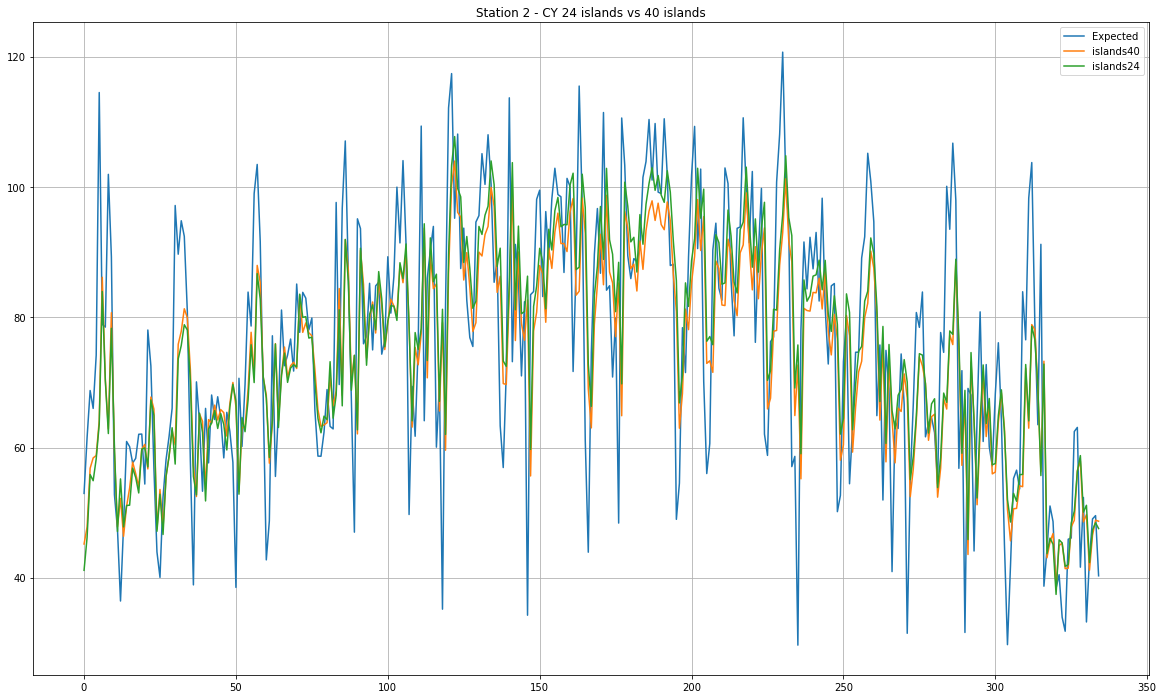

In [39]:
fig, ax = pyplot.subplots(nrows=1, ncols=1, figsize=(20, 12), sharex=True, sharey=True)
ax.plot(predictions["expected"].squeeze())
ax.plot(predictions[f"islands{current_index}"].squeeze())
ax.plot(predictions[f"islands{best_index}"].squeeze())
ax.set_title(f"Station {series_index} - {country} {best_indices[country]} islands vs {num_islands} islands")
ax.grid(True)
ax.legend(["Expected", f"islands{current_index}", f"islands{best_index}"])